XI. THE NINE SITUATIONS 
1. Sun Tzŭ said: The art of war recognises nine varieties of ground: 
        (1) dispersive ground; 
        (2) facile ground; 
        (3) contentious ground; 
        (4) open ground; 
        (5) ground of intersecting highways; 
        (6) serious ground; 
        (7) difficult ground; 
        (8) hemmed-in ground; 
        (9) desperate ground.


2. When a chieftain is fighting in his own territory, it is dispersive ground. 
3. When he has penetrated into hostile territory, but to no great distance, it is facile ground.
4. Ground the possession of which imports great advantage to either side, is contentious ground.
5. Ground on which each side has liberty of movement is open ground. 
6. Ground which forms the key to three contiguous states, so that he who occupies it first has most of the Empire at his command, is ground of intersecting highways.
7. When an army has penetrated into the heart of a hostile country, leaving a number of fortified cities in its rear,  it is serious ground. 
8. Mountain forests, rugged steeps, marshes and fens—all country that is hard to traverse: this is difficult ground. 
9. Ground which is reached through narrow gorges, and from which we can only retire by tortuous paths, so that a small number of the enemy would suffice to crush a large body of our men: this is hemmed-in ground.
10. Ground on which we can only be saved from destruction by fighting without delay, is desperate ground. 


11. On dispersive ground, therefore, fight not. On facile ground, halt not. On contentious ground, attack not. 
12. On open ground, do not try to block the enemy's way. On ground of intersecting highways, join hands with your allies. 
13. On serious ground, gather in plunder. On difficult ground, keep steadily on the march. 
14. On hemmed-in ground, resort to stratagem. On desperate ground, fight. 


Isolation game types of "ground"

    (1) dispersive ground - the opponent has more moves than the player
    (2) facile ground - the player has more moves than the opponent
    (3) contentious ground - the number of common moves
    (4) open ground - center moves
    (5) intersecting highways - will ignore for a two player game
    (6) serious ground - the opponent has much less moves than the player
    (7) difficult ground - precious few available moves for the player
    (8) hemmed-in ground - very, very few available moves for the player
    (9) desperate ground - dire situation
    
    
 Isolation game heuristics
 
 
 1. penalize the dispersive ground - 
 2. encourage the facile ground
 3. penalize the contentious ground
 4. encourage the open ground, penalize the common moves
 5. ignored
 6. encourage++ the serious ground
 7. penalize ++ the difficult ground
 8. penalize +++ the hemmed-in ground
 9. forfait
 

# The competing heuristics
This is the code of the three heuristics the tournament used:

```python
def added_centrality_sum_heuristic(game, player):
    opponent = game.get_opponent(player)
    opponent_moves = game.get_legal_moves(opponent)
    player_moves = game.get_legal_moves()
    if not opponent_moves:
        return float("inf")
    if not player_moves:
        return float("-inf")
    return float(len(player_moves) - len(opponent_moves) + 
        sum(centrality_measure(game, m) for m in player_moves) + 
        common_moves_measure(game, player) + 
        interfering_moves_measure(game, player))

def weighted_centrality_heuristic(game, player):

  '''
    opponent_weight - avoid choices where the opponent has more moves
    center_weight - favorize the center more
    '''   
    if game.is_winner(player) or game.is_loser(player):
        return game.utility(player)

    central_column = math.ceil(game.width/2.)
    central_row = math.ceil(game.height/2.)
    num_all_available_moves = float(game.width * game.height)
    num_blank_spaces = len(game.get_blank_spaces())
    decay = num_blank_spaces/num_all_available_moves

    player_moves = game.get_legal_moves(player)
    opponent_moves = game.get_legal_moves(game.get_opponent(player))
    num_player_moves = len(player_moves)
    num_opponent_moves = len( opponent_moves )

    player_weight = 1
    opponent_weight = 2
    center_weight = 2

    for move in player_moves:
        if move[0] == central_row or move[1] == central_column:
            player_weight *= (center_weight * decay)

    for move in opponent_moves:
        if move[0] == central_row or move[1] == central_column:  
            opponent_weight  *= (center_weight * decay)

    return float((num_player_moves * player_weight) - 
        (num_opponent_moves * opponent_weight)) 
        
```

# The Sun-Tzu heuristic

This heuristic is based on Sun-Tzu recommendations above. We modelled the recommendations via intial weights and the ratio of player vs opponent moves. Through a good amount of trial and error we noticed the heuristic performs differenty over 21,000 games for different  intial weights. We kept the weights for the centrality (open ground) the same.

``` python
def sun_tzu_heuristic(game, player):

    if game.is_winner(player) or game.is_loser(player):
        return game.utility(player)

    dispersive_ground_weight = 2.0
    facile_ground_weight = 4.0
    contentious_ground_weight = 2.0
    open_ground_weight = 2.0
    serious_ground_weight = 8.0
    difficult_ground_weight = 4.0
    hemmed_in_ground_weight = 8.0

    central_column = math.ceil(game.width/2.)
    central_row = math.ceil(game.height/2.)
    num_all_available_moves = float(game.width * game.height)
    num_blank_spaces = len(game.get_blank_spaces())
    decay = num_blank_spaces/num_all_available_moves

    player_moves = game.get_legal_moves(player)
    opponent_moves = game.get_legal_moves(game.get_opponent(player))
    num_player_moves = len(player_moves)
    num_opponent_moves = len( opponent_moves )
    common_moves = len(find_common_moves(game, player))

    dispersive_ground = num_opponent_moves/num_player_moves if num_player_moves !=0 else num_opponent_moves
    facile_ground = num_player_moves/num_opponent_moves if num_opponent_moves !=0 else num_player_moves
    contentious_ground = common_moves/num_blank_spaces if common_moves !=0 else 1.
    serious_ground = num_player_moves/num_opponent_moves if num_opponent_moves !=0 else num_player_moves
    difficult_ground = num_opponent_moves/num_player_moves if num_player_moves !=0 else num_opponent_moves
    hemmed_in_ground = num_opponent_moves/num_player_moves if num_player_moves !=0 else num_opponent_moves

    dispersive_ground = dispersive_ground if dispersive_ground !=0 else 1
    facile_ground = facile_ground if facile_ground !=0 else 1
    serious_ground = serious_ground if serious_ground != 0 else 1
    difficult_ground = difficult_ground if difficult_ground !=0 else 1
    hemmed_in_ground = hemmed_in_ground if hemmed_in_ground !=0 else 1

    player_weight=1.0
    opponent_weight = 2.0

    #handle open_ground/center moves
    for move in player_moves:
        if move[0] == central_row or move[1] == central_column:
            player_weight *= (open_ground_weight * decay)

    for move in opponent_moves:
        if move[0] == central_row or move[1] == central_column:  
            opponent_weight  *= (open_ground_weight * decay)

    #factor ground weights only once
    player_weight *= facile_ground_weight*serious_ground_weight
    opponent_weight *= dispersive_ground_weight*contentious_ground_weight*difficult_ground_weight*hemmed_in_ground_weight

    player_weight *= (decay * facile_ground) * (decay * serious_ground)
    opponent_weight *= (decay * dispersive_ground) * (decay * contentious_ground) * (decay * difficult_ground) * (decay * hemmed_in_ground)

    return float((num_player_moves * player_weight) - 
        (num_opponent_moves * opponent_weight))            

```

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sn

The data set contains the win rates for 330 runs of the tournament.py. Each tournament plays 70 games for each custom agent in competition. There are about 23,100 games played for each heuristic.

In [13]:
tournament_results = pd.read_csv('variant-1.csv')
tournament_results.head()
#tournament_results["AB_Custom3"]

,AB_Improved,AB_Custom,AB_Custom2,AB_Custom3,Batch
0,61.4,52.9,58.6,65.7,2
1,54.3,55.7,61.4,57.1,2
2,62.9,58.6,65.7,58.6,2
3,60.0,61.4,55.7,51.4,2
4,60.0,61.4,71.4,65.7,3


In [15]:
tournament_results[[0, 1, 2, 3]].describe()

,AB_Improved,AB_Custom,AB_Custom2,AB_Custom3
count,330.000000,330.000000,330.000000,330.000000
mean,63.904848,58.102424,64.298182,63.570000
std,4.544114,4.710719,4.830979,4.200497
min,50.000000,44.300000,50.000000,51.400000
25%,61.400000,54.300000,61.400000,61.400000
50%,64.300000,58.600000,64.300000,64.300000
75%,67.100000,61.400000,67.100000,67.100000
max,75.700000,68.600000,78.600000,75.700000


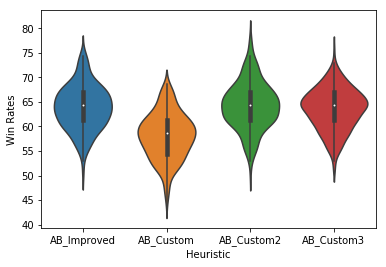

In [11]:
sn.violinplot(data=tournament_results[[0, 1, 2, 3]], split=True)
plt.ylabel('Win Rates')
plt.xlabel('Heuristic')
plt.show()

## Hypothesis
We'd like to determine if there is a significant difference in the mean win rates recorded for the AB_Improved heuristic and the  win rates recorded for the Sun Tzu heuristic with the parameters above. The AB_Improved heuristic scored a mean average of $\bar{x}_h=63.904848$. The mean average for the Sun Tzu Heuristic is $\bar{x}_f=63.570000$ We choose as our test criterium an alpha level of 5%. So our hypothesis states:

|Hypothesis||$\alpha = .05$|
|---:|:---:|---|:---|
|$H_0:$|$\mu_h = \mu_f$|There is no significant difference in mean win rates for the two heurisics|
|$H_a:$|$\mu_h \neq \mu_f$|There is a significant difference in mean win rates for the two heuristics|

Note that the hypothesis is written to denote the whole population, not just the sample.

In [17]:
t_statistic, p = stats.ttest_rel(tournament_results["AB_Improved"], tournament_results["AB_Custom3"])
t_statistic, p

(1.0312133207383287, 0.30319826440468789)

In [18]:
# To test our alternative hypothesis
alpha = .05
p < alpha / 2 # two sided

False

There is no statistical difference between AB_Improved and the Sun Tzu Heuristic. We perform the same check for the AB_Custom heuristic.

In [19]:
t_statistic, p = stats.ttest_rel(tournament_results["AB_Improved"], tournament_results["AB_Custom"])
t_statistic, p

(16.241661188205565, 5.6696441599584396e-44)

In [20]:
# To test our alternative hypothesis
alpha = .05
p < alpha / 2 # two sided

True

In this case we could say that the AB_Custom heuristic is worse than the AB_Improved heurstic since it has a statistically lower win rate.